### Part 1: Creating object for basic ML functions

In [84]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# how derivatives work

a = 2.0
b = -3.0
c = 10.0

h = 0.0000001 # small nudge in pos direction

f1 = a*b + c
c += h  # wrt c
f2 = a*b + c

print('slope', (f2-f1)/h)

slope 0.999999993922529


In [71]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None   # by default if it is leaf node, don't apply any fxn
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # derivative of addition is just 1*itself
            other.grad += 1.0 * out.grad
        
        out._backward = _backward # stores function in out (replaces lambda: None)

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
            
        return out
    
    def backward(self):
        
        topo = []   # topo sort to determine order to compute grads
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)  # append self at the end after children
        build_topo(self)
        
        self.grad = 1.0 # derivative of itself it 1.0; starting value
        for node in reversed(topo): # reverse order for chain rule (R->L in comp graph)
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [54]:
# draw computational graph

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)  # recursively builds root and all childs of root
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

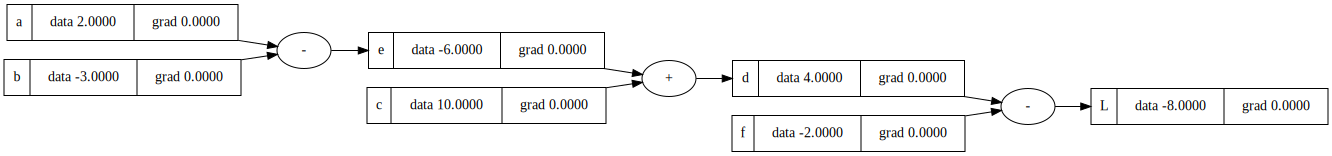

In [55]:
draw_dot(L)

In [74]:
# neuron

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [75]:
o.backward()

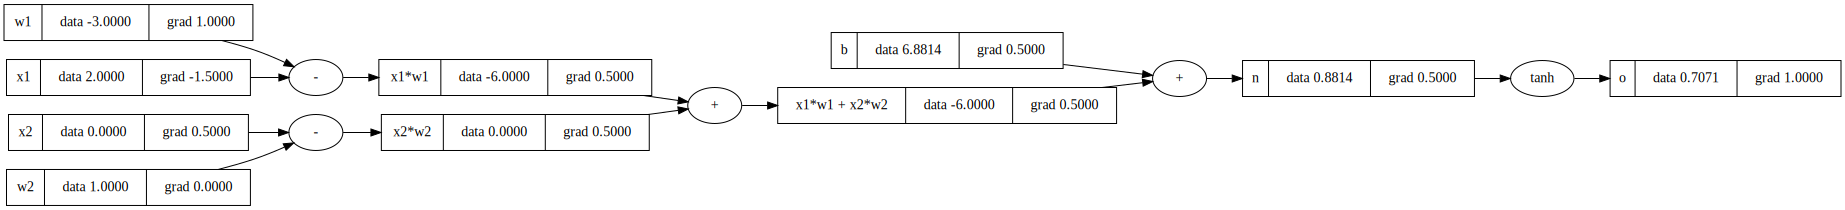

In [76]:
draw_dot(o)

### Part 2: Implementing NN

In [107]:
# new Value class with added functionality

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None   # by default if it is leaf node, don't apply any fxn
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # cast as Value if not already
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # derivative of addition is just 1*itself
            other.grad += 1.0 * out.grad
        
        out._backward = _backward # stores function in out (replaces lambda: None)

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad  # power rule
        out._backward = _backward
    
        return out

    def __rmul__(self, other):  # right mul; looks at second operand
        return self * other # calls __mul__ but with other * self
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
            
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []   # topo sort to determine order to compute grads
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)  # append self at the end after children
        build_topo(self)
        
        self.grad = 1.0 # derivative of itself it 1.0; starting value
        for node in reversed(topo): # reverse order for chain rule (R->L in comp graph)
            node._backward()

In [100]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # random initialize w's and b's
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        z = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # z=wx+b
        out = z.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]    # concatenate lists
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]   # create neurons with weights, nout is how many neurons needed (each out produces 1 output)
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # gets out for each neuron by calling it
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]  # accumulate all neuron params
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts  # size is the data layer + hidden laters
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]    # each layer's input is the output of previous layer
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [102]:
# single prediction

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.12138838923415027)

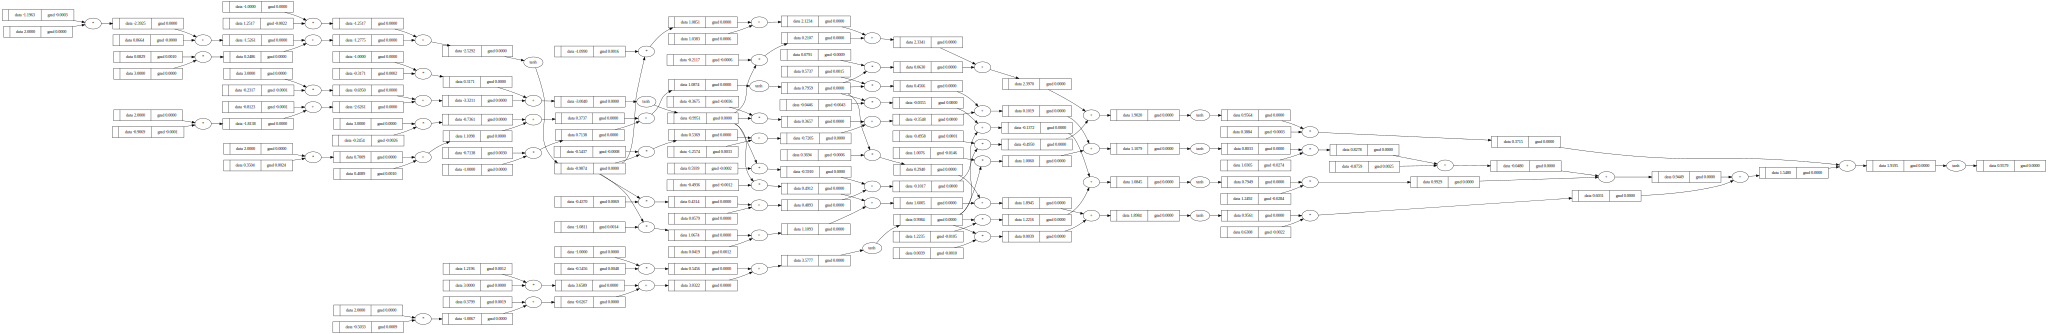

In [114]:
draw_dot(n(x))

In [103]:
print(len(n.parameters()))

41


In [104]:
# example of tuning weights

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [110]:
# create training cycle

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters(): # zero_grad
        p.grad = 0.0
    
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data -= 0.1 * p.grad

    print(k, loss.data)

0 0.016132393978621703
1 0.015575675154919899
2 0.015055496237431031
3 0.014568373827655325
4 0.014111253759229975
5 0.013681447012934396
6 0.013276576765772187
7 0.012894534383752772
8 0.012533442646434287
9 0.012191624855398014
10 0.011867578758148322
11 0.011559954434840258
12 0.011267535463318051
13 0.01098922280968373
14 0.010724020995524424
15 0.010471026175388212
16 0.010229415823914387
17 0.009998439784844475
18 0.009777412476751523
19 0.009565706084875272


In [112]:
ypred

[Value(data=0.9574064663479045),
 Value(data=-0.9342076243727525),
 Value(data=-0.971997308294538),
 Value(data=0.9486316289680595)]

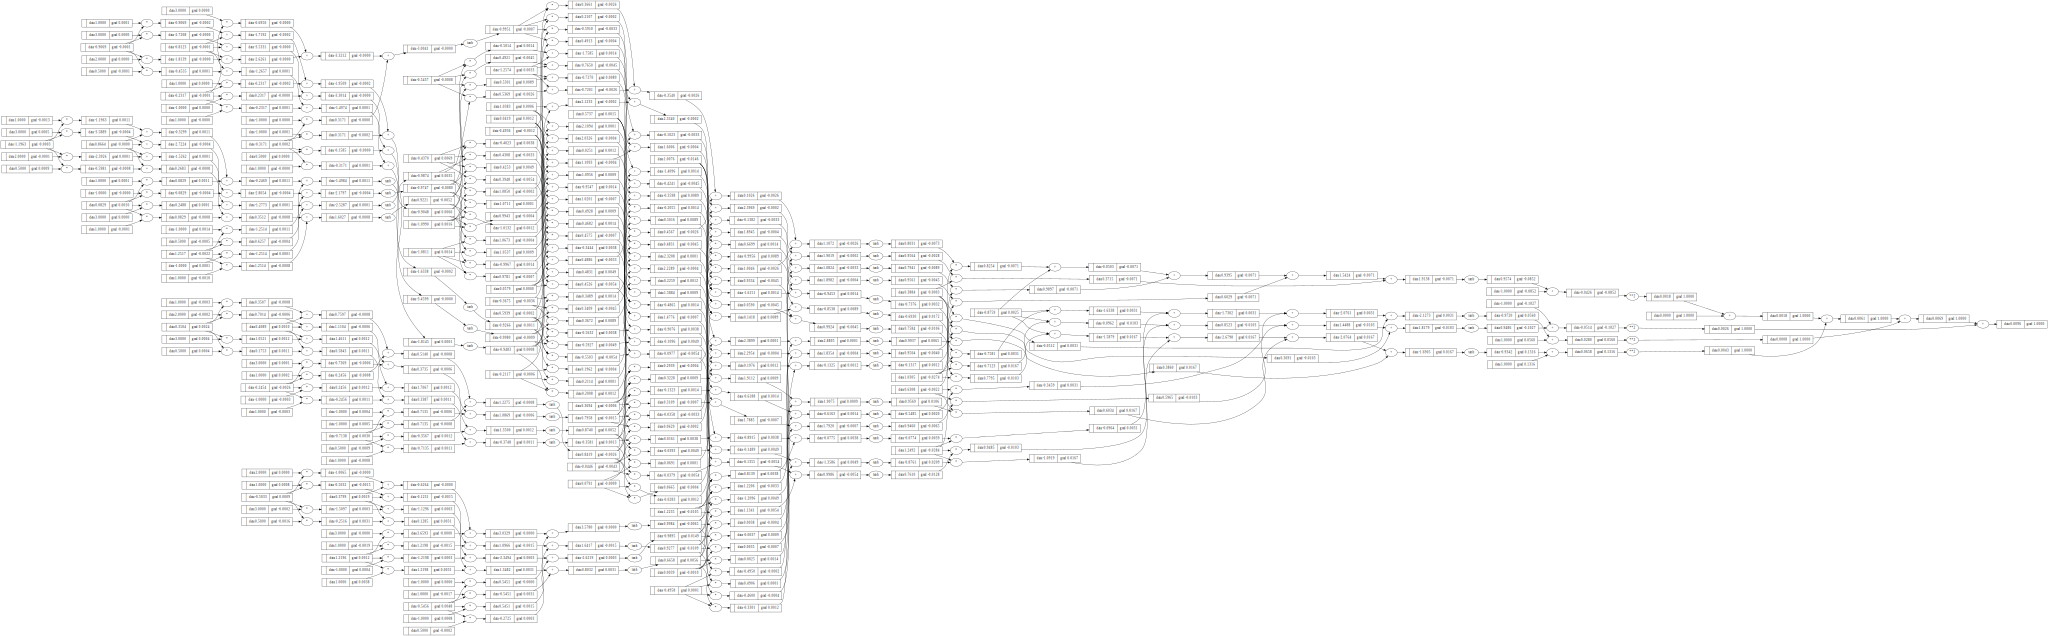

In [115]:
draw_dot(loss)